### Comparing the performance of XGBoost with foundation models using external dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import seaborn
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [251]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Running on CPU with more than 200 samples may be slow.*",
    category=UserWarning
)

#### Heart disease databases: Cleveland, Hungary, Switzerland, VA Long Beach and Statlog are taken from https://archive.ics.uci.edu/dataset 

Attribute information

      -- 1. age       
      -- 2. sex       
      -- 3. chest pain type  (4 values)       
      -- 4. resting blood pressure  
      -- 5. serum cholestoral in mg/dl      
      -- 6. fasting blood sugar > 120 mg/dl       
      -- 7. resting electrocardiographic results  (values 0,1,2) 
      -- 8. maximum heart rate achieved  
      -- 9. exercise induced angina    
      -- 10. oldpeak = ST depression induced by exercise relative to rest   
      -- 11. the slope of the peak exercise ST segment     
      -- 12. number of major vessels (0-3) colored by flourosopy        
      -- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect     



In [119]:
data1 = pd.read_excel(r"C:\Users\lavan\Downloads\RA_NUIG\datasets\heart_disease_uci.xlsx", na_values=["", " ", "NA", "N/A"])
data1 = data1.replace(r"^\s*$", pd.NA, regex=True)
data1 = data1.rename(columns={'num': 'disease_present'}) # Renaming target column
data1 = data1.drop(['id', 'dataset'], axis=1) 


data1['disease_present'] = data1.disease_present.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})

#df.head()
#data1.info()

In [120]:
sex_map = {
    'female': 0,
    'male': 1
}

cp_map = {
    'typical angina': 1,
    'atypical angina': 2,
    'non-anginal': 3,
    'asymptomatic': 4
}

restecg_map = {
    'normal': 0,
    'st-t abnormality': 1,
    'lv hypertrophy': 2
}

slope_map = {
    'upsloping': 1,
    'flat': 2,
    'downsloping': 3
}

thal_map = {
    'normal': 3,
    'fixed defect': 6,
    'reversable defect': 7   # keep spelling as-is
}


In [121]:
def recode_text(col, mapping):
    return (
        col
        .astype(str)
        .str.strip()
        .str.lower()
        .map(mapping)
    )


data1['sex'] = recode_text(data1['sex'], sex_map)
data1['cp'] = recode_text(data1['cp'], cp_map)
data1['restecg'] = recode_text(data1['restecg'], restecg_map)
data1['slope'] = recode_text(data1['slope'], slope_map)
data1['thal'] = recode_text(data1['thal'], thal_map)


In [122]:
data1[['sex','cp','restecg','slope','thal']].apply(
    lambda s: sorted(s.dropna().unique())
)


sex                 [0, 1]
cp            [1, 2, 3, 4]
restecg    [0.0, 1.0, 2.0]
slope      [1.0, 2.0, 3.0]
thal       [3.0, 6.0, 7.0]
dtype: object

In [123]:

columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalch", "exang", "oldpeak",
    "slope", "ca", "thal" , "num"
]

data2 = pd.read_csv(
    r"C:\Users\lavan\Downloads\RA_NUIG\datasets\heart.dat",
    sep=r"\s+",
    header=None,
    names=columns
)
data2 = data2.rename(columns={'num': 'disease_present'}) # Renaming target column
data2['disease_present'] = data2.disease_present.map({1: 0, 2: 1 })# , 2: 1, 3: 1, 4: 1})

#df.head()
data2.info()

cat_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']

#data2[cat_cols] = data2[cat_cols].astype('Int64').astype(str)
#data2['age'] = data2['age'].astype(int)

cat_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']

for c in cat_cols:
    data1[c] = data1[c].astype('Int64')   # nullable integer
    data2[c] = data2[c].astype('Int64')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              270 non-null    float64
 1   sex              270 non-null    float64
 2   cp               270 non-null    float64
 3   trestbps         270 non-null    float64
 4   chol             270 non-null    float64
 5   fbs              270 non-null    float64
 6   restecg          270 non-null    float64
 7   thalch           270 non-null    float64
 8   exang            270 non-null    float64
 9   oldpeak          270 non-null    float64
 10  slope            270 non-null    float64
 11  ca               270 non-null    float64
 12  thal             270 non-null    float64
 13  disease_present  270 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 29.7 KB


In [124]:
data1['source'] = 'uci_heart'
data2['source'] = 'uci_statlog'

df = pd.concat([data1, data2], ignore_index=True)

df.shape

(1190, 15)

In [125]:
df.info()
df[cat_cols].nunique()
df['disease_present'].value_counts()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              1190 non-null   float64
 1   sex              1190 non-null   Int64  
 2   cp               1190 non-null   Int64  
 3   trestbps         1131 non-null   float64
 4   chol             1160 non-null   float64
 5   fbs              1100 non-null   float64
 6   restecg          1188 non-null   Int64  
 7   thalch           1135 non-null   float64
 8   exang            1135 non-null   float64
 9   oldpeak          1128 non-null   float64
 10  slope            881 non-null    Int64  
 11  ca               579 non-null    float64
 12  thal             704 non-null    Int64  
 13  disease_present  1190 non-null   int64  
 14  source           1190 non-null   object 
dtypes: Int64(5), float64(8), int64(1), object(1)
memory usage: 145.4+ KB


disease_present
1    629
0    561
Name: count, dtype: int64

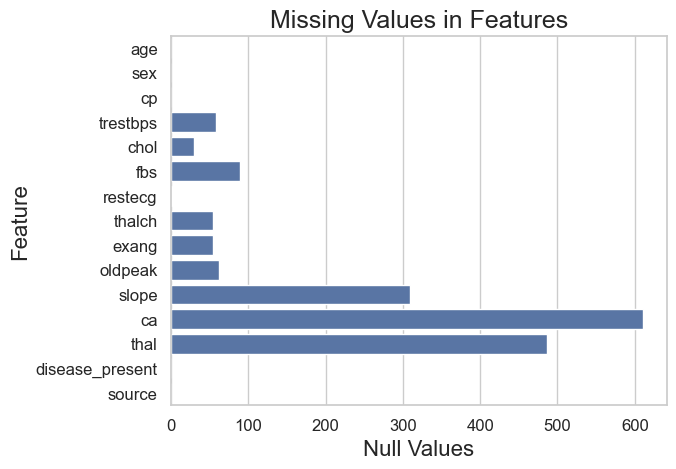

In [127]:
df_null = pd.DataFrame(df.isnull().sum().reset_index())
df_null.columns = ['feature', 'null_values']
df_null

# Barchart for null values
sns.barplot(y=df_null['feature'], x=df_null['null_values'], orient='h')
plt.title('Missing Values in Features', fontsize=18)
plt.xlabel('Null Values', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


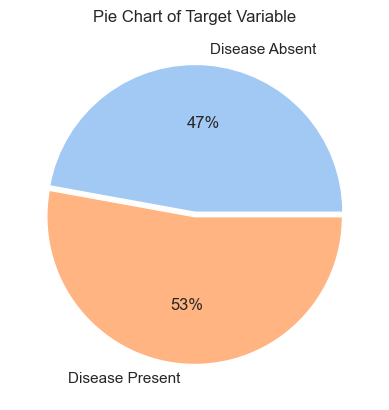

In [128]:
# Pie-chart of Target feature - disease_present

unique_values = df['disease_present'].unique()
counts = df['disease_present'].value_counts().sort_values()
percentages = counts / counts.sum() * 100
plt.pie(percentages, labels=['Disease Absent', 'Disease Present'],
        colors= seaborn.color_palette('pastel'), explode=[0.02,0.01], autopct='%.0f%%')
plt.title('Pie Chart of Target Variable')
plt.show()

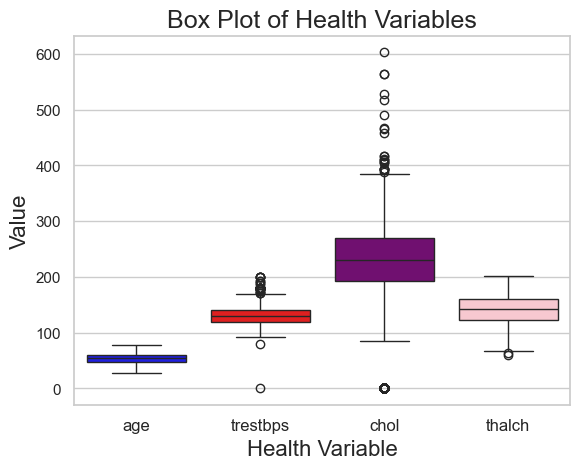

In [129]:

health_variables = ['age', 'trestbps', 'chol', 'thalch']
colors = ['blue', 'red', 'purple', 'pink']
sns.set(style="whitegrid")

ax = sns.boxplot(data=df[health_variables], palette=colors)

ax.set_xticks(range(len(health_variables)))
ax.set_xticklabels(health_variables, fontsize=12)

ax.set_xlabel('Health Variable', fontsize=16)
ax.set_ylabel('Value', fontsize=16)
ax.set_title('Box Plot of Health Variables', fontsize=18)

plt.show()

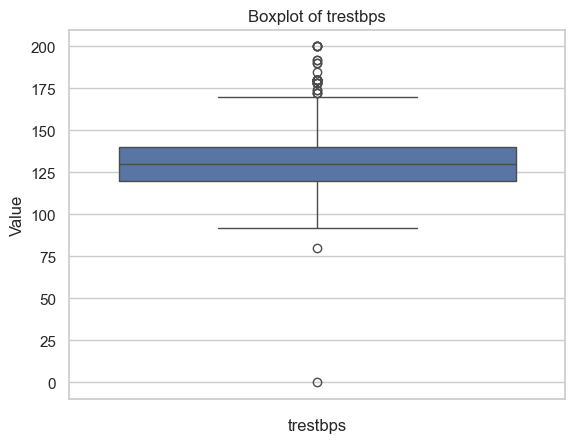

In [130]:
numerical_features = ['age', 'trestbps', 'chol', 'fbs', 'exang', 'oldpeak', 'thalch']
feature = 'trestbps'
sns.boxplot( y=df[feature] );
plt.xlabel(feature)
plt.ylabel('Value')
plt.title('Boxplot of {}'.format(feature))
plt.show()

In [133]:

X = df.drop(columns=['disease_present', 'source'])
y = df['disease_present']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [134]:
#============================ XGBoost ============================#

Accuracy for test set for XGBoost = 0.8851851851851852

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       150
           1       0.89      0.84      0.87       120

    accuracy                           0.89       270
   macro avg       0.89      0.88      0.88       270
weighted avg       0.89      0.89      0.88       270



Text(82.08333333333333, 0.5, 'Predicted')

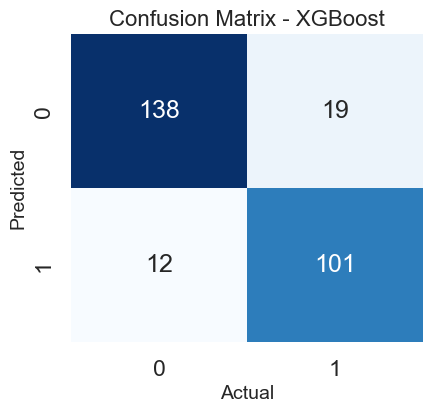

In [179]:
import xgboost as xg

xgb_params = dict(
    objective="binary:logistic", eval_metric="logloss",
    reg_lambda=5, learning_rate=0.05, max_depth=6, n_estimators=100,
    reg_alpha=0, gamma=5, subsample=0.8, colsample_bytree=1.0,
    tree_method="hist", random_state=42, n_jobs=-1
)

xg = xg.XGBClassifier(**xgb_params)

xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)

cm_test = confusion_matrix(y_pred, y_test)
#print("confusion matrix for test set", cm_test)
TP = cm_test[1, 1]  # True Positives
FP = cm_test[0, 1]  # False Positives
TN = cm_test[0, 0]  # True Negatives
FN = cm_test[1, 0]  # False Negatives

precision = TP/(TP+FP)
recall = TP/(TP+FN)
print("Accuracy for test set for XGBoost =", (TN + TP)/len(y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
y_pred_train = xg.predict(X_train)

for i in range(0, len(y_pred_train)):
    if y_pred_train[i]>= 0.5:       # setting threshold to .5
       y_pred_train[i]=1
    else:
       y_pred_train[i]=0
        # Confusion Matrix Plot for Test & Training set
# Plot Confusion Matrices
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - XGBoost', fontsize = 16)
plt.xlabel('Actual', fontsize = 14)
plt.ylabel('Predicted', fontsize = 14)

c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tabpfn\classifier.py:616: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


Accuracy for test set for TabPFN = 0.9888888888888889

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.99      0.98      0.99       120

    accuracy                           0.99       270
   macro avg       0.99      0.99      0.99       270
weighted avg       0.99      0.99      0.99       270



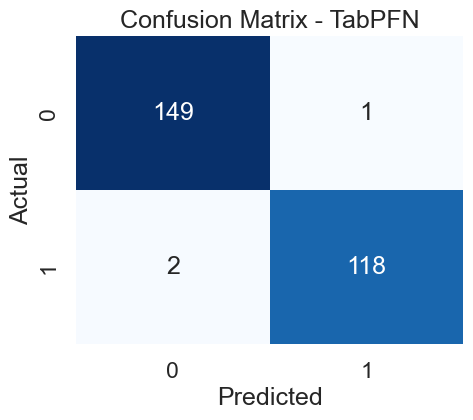

In [ ]:
from tabpfn import TabPFNClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Model ---
tabpfn = TabPFNClassifier(device="cpu")
tabpfn.fit(X_train, y_train)

# --- Predictions ---
y_pred_test_proba = tabpfn.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_test_proba >= 0.5).astype(int)

# --- Confusion Matrix ---
cm_test = confusion_matrix(y_test, y_pred_test)

TP = cm_test[1, 1]
FP = cm_test[0, 1]
TN = cm_test[0, 0]
FN = cm_test[1, 0]

print("Accuracy for test set for TabPFN =", (TN + TP) / len(y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# --- Plot ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - TabPFN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy for test set for TabICL = 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       120

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



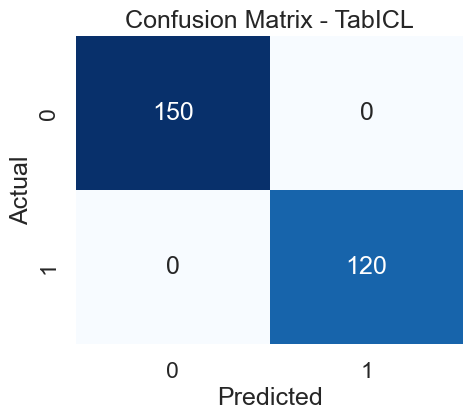

In [ ]:
from tabicl import TabICLClassifier

tabicl_model = TabICLClassifier()
tabicl_model.fit(X_train, y_train)

# --- Predictions ---
y_pred_test_proba = tabicl_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_test_proba >= 0.5).astype(int)

# --- Confusion Matrix ---
cm_test = confusion_matrix(y_test, y_pred_test)

TP = cm_test[1, 1]
FP = cm_test[0, 1]
TN = cm_test[0, 0]
FN = cm_test[1, 0]

print("Accuracy for test set for TabICL =", (TN + TP) / len(y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# --- Plot ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - TabICL')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


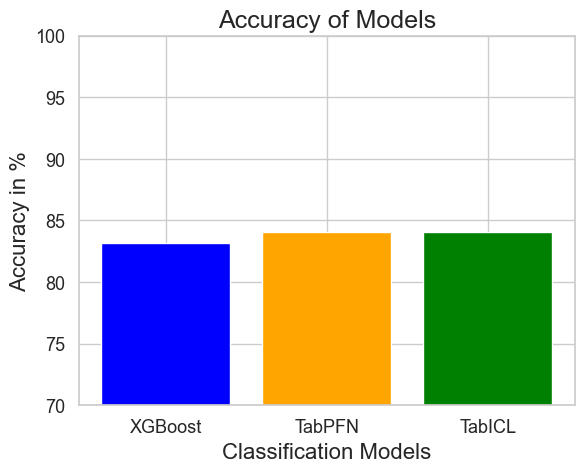

In [ ]:
# Bar plot


models = ['XGBoost', 'TabPFN', 'TabICL']
accuracy = [83.19, 84.03, 84.03]  #


#plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['blue', 'orange', 'green'])

plt.xlabel('Classification Models', fontsize=16)
plt.ylabel('Accuracy in %', fontsize=16)
plt.title('Accuracy of Models', fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.ylim(70, 100)  # Set the y-axis limits
plt.show()


In [140]:

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    brier_score_loss
)


In [141]:
def compute_metrics(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "PR_AUC": average_precision_score(y_true, y_proba),
        "Sensitivity": tp / (tp + fn) if (tp + fn) > 0 else np.nan,
        "Specificity": tn / (tn + fp) if (tn + fp) > 0 else np.nan,
        "Brier": brier_score_loss(y_true, y_proba)
    }


In [142]:
uci_heart = df[df["source"] == "uci_heart"]
uci_statlog = df[df["source"] == "uci_statlog"]

X_heart = uci_heart.drop(columns=["disease_present", "source"])
y_heart = uci_heart["disease_present"].values

X_statlog = uci_statlog.drop(columns=["disease_present", "source"])
y_statlog = uci_statlog["disease_present"].values


In [143]:
models = {
    "XGBoost": xg,      # trained earlier
    "TabPFN": tabpfn,
    "TabICL": tabicl_model
}


In [144]:
results = []

for model_name, model in models.items():
    for dataset_name, X_test, y_test in [
        ("UCI Heart", X_heart, y_heart),
        ("UCI Statlog", X_statlog, y_statlog),
    ]:
        y_proba = model.predict_proba(X_test)[:, 1]
        metrics = compute_metrics(y_test, y_proba)

        results.append({
            "Model": model_name,
            "Dataset": dataset_name,
            **metrics
        })

In [145]:
results_df = pd.DataFrame(results).round(3)
results_df


,Model,Dataset,ROC_AUC,PR_AUC,Sensitivity,Specificity,Brier
0,XGBoost,UCI Heart,0.986,0.979,0.971,0.954,0.028
1,XGBoost,UCI Statlog,1.000,1.000,0.992,0.993,0.004
2,TabPFN,UCI Heart,0.983,0.985,0.957,0.893,0.049
3,TabPFN,UCI Statlog,1.000,0.999,0.983,0.993,0.011
4,TabICL,UCI Heart,0.997,0.998,0.972,0.968,0.020
5,TabICL,UCI Statlog,1.000,1.000,1.000,1.000,0.002


#### Framingham Heart Study: The dataset is a rather small subset of possible FHS dataset, having 4240 observations and 16 variables. The variables are as follows:



1. sex : the gender of the observations.  
2. age : Age at the time of medical examination in years.
3. education : A categorical variable of the participants education, with the levels: Some high school (1), high school/GED (2), some college/vocational school (3), college (4)
4. currentSmoker: Current cigarette smoking at the time of examinations
5. cigsPerDay: Number of cigarettes smoked each day
6. BPmeds: Use of Anti-hypertensive medication at exam
7. prevalentStroke: Prevalent Stroke (0 = free of disease)
8. prevalentHyp: Prevalent Hypertensive. Subject was defined as hypertensive if treated
9. diabetes: Diabetic according to criteria of first exam treated
10. totChol: Total cholesterol (mg/dL)
11. sysBP: Systolic Blood Pressure (mmHg)
12. diaBP: Diastolic blood pressure (mmHg)
13. BMI: Body Mass Index, weight (kg)/height (m)^2
14. heartRate: Heart rate (beats/minute)
15. glucose: Blood glucose level (mg/dL)

the response variable : + TenYearCHD : The 10 year risk of coronary heart disease(CHD).

In [257]:
data3 = pd.read_excel(
    r"C:\Users\lavan\Downloads\RA_NUIG\datasets\framingham.xlsx",
    na_values=["", " ", "NA", "N/A"]
)

data3 = data3.replace(r"^\s*$", pd.NA, regex=True)

data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


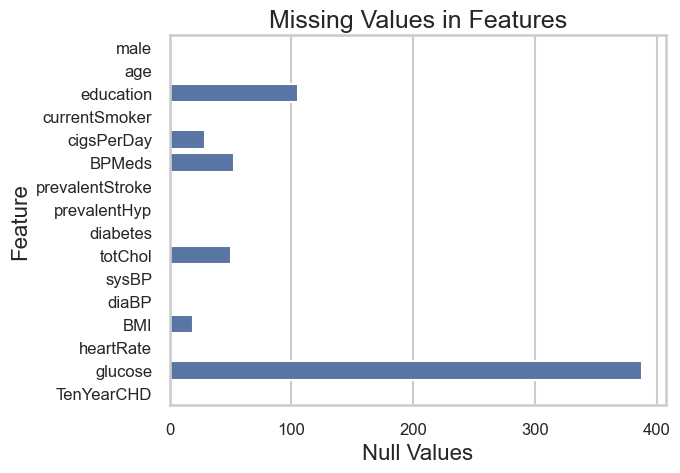

In [258]:
df_null = pd.DataFrame(data3.isnull().sum().reset_index())
df_null.columns = ['feature', 'null_values']
df_null

# Barchart for null values
sns.barplot(y=df_null['feature'], x=df_null['null_values'], orient='h')
plt.title('Missing Values in Features', fontsize=18)
plt.xlabel('Null Values', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


<Axes: >

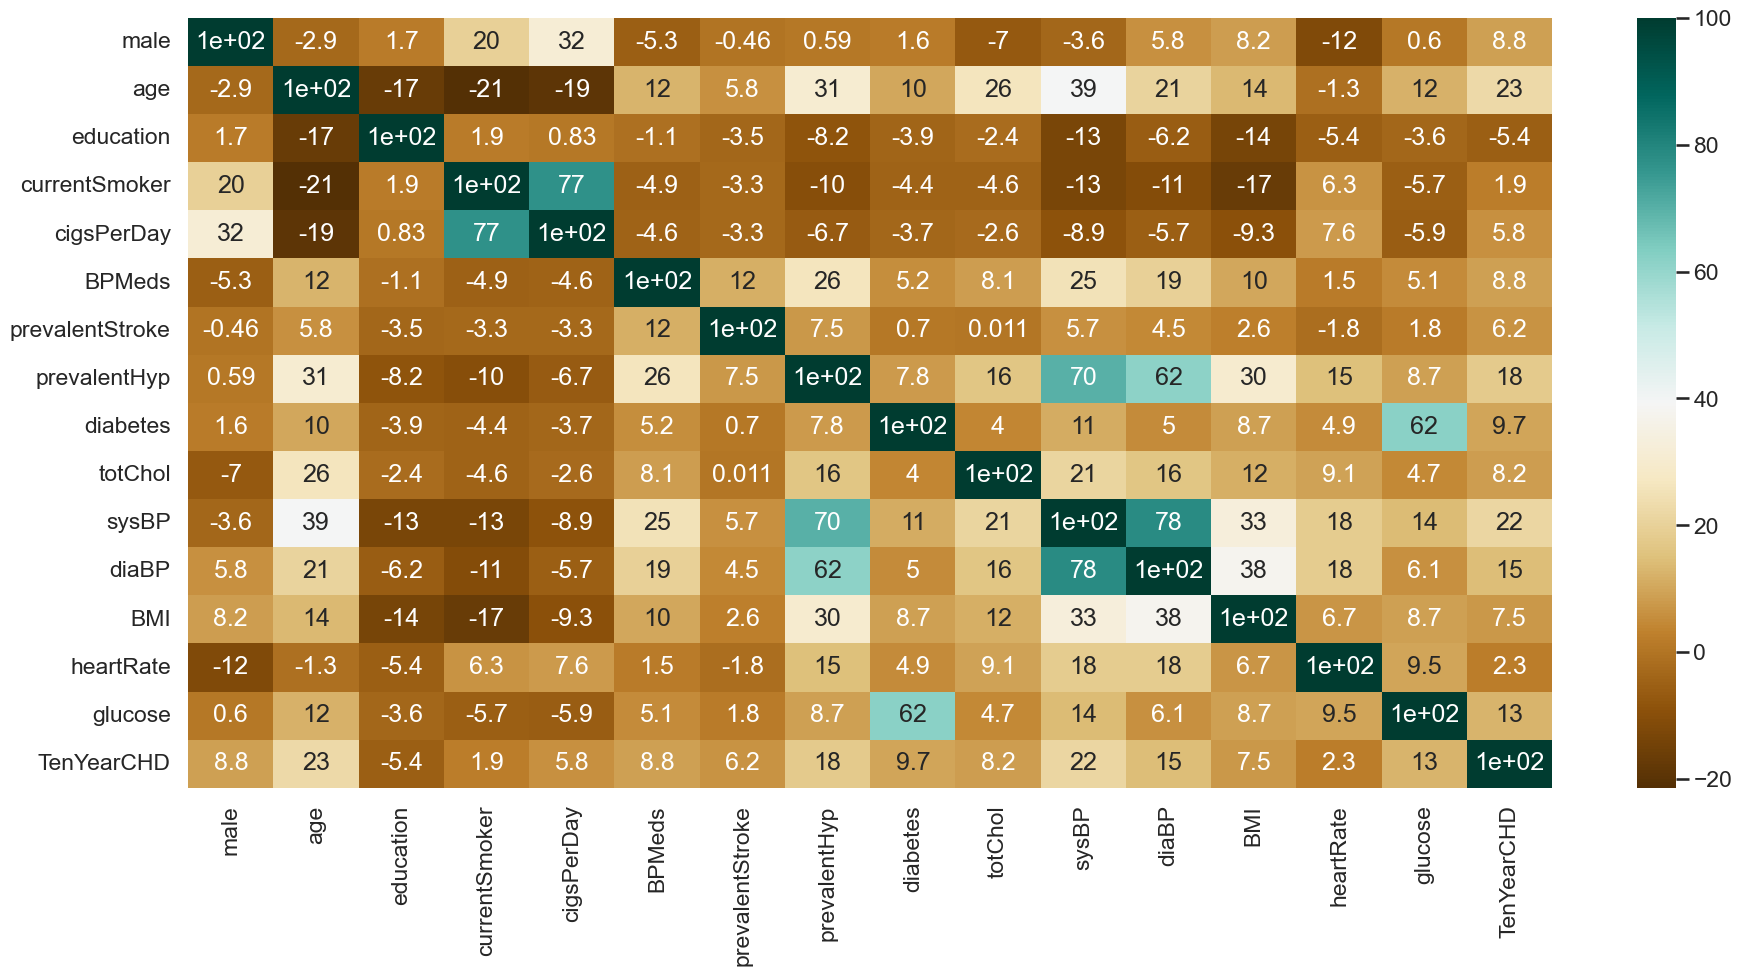

In [246]:
 

sns.set_context('talk')
plt.figure(figsize=(22,10))
sns.heatmap(data3.corr()*100, annot=True, cmap='BrBG')

Text(0.5, 1.0, 'Target Class Count')

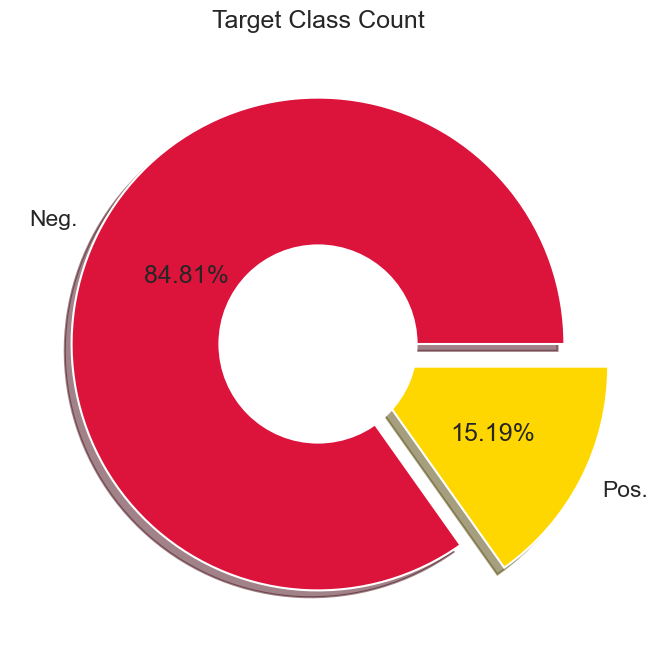

In [247]:
#Target Class count

plt.figure(figsize=(8,8))
plt.pie(data3['TenYearCHD'].value_counts(), labels=['Neg.','Pos.'], autopct='%1.2f%%', explode=[0,0.2], shadow=True, colors=['crimson','gold'])
my_circle = plt.Circle( (0,0), 0.4, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Target Class Count')

In [259]:
X_fram = data3.drop(columns=["TenYearCHD"])
y_fram = data3["TenYearCHD"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fram, y_fram, test_size = 0.2, random_state = 42)

Accuracy for test set for XGBoost = 0.8549528301886793

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       722
           1       1.00      0.02      0.05       126

    accuracy                           0.85       848
   macro avg       0.93      0.51      0.48       848
weighted avg       0.88      0.85      0.79       848



Text(82.08333333333333, 0.5, 'Predicted')

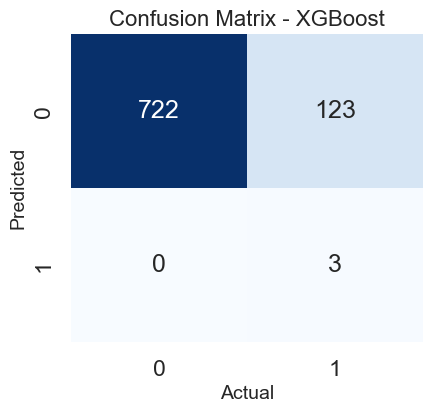

In [ ]:
import xgboost as xg

xgb_params = dict(
    objective="binary:logistic", eval_metric="logloss",
    reg_lambda=5, learning_rate=0.05, max_depth=6, n_estimators=100,
    reg_alpha=0, gamma=5, subsample=0.8, colsample_bytree=1.0,
    tree_method="hist", random_state=42, n_jobs=-1
)

xg = xg.XGBClassifier(**xgb_params)

xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)

cm_test = confusion_matrix(y_pred, y_test)
#print("confusion matrix for test set", cm_test)
TP = cm_test[1, 1]  # True Positives
FP = cm_test[0, 1]  # False Positives
TN = cm_test[0, 0]  # True Negatives
FN = cm_test[1, 0]  # False Negatives

precision = TP/(TP+FP)
recall = TP/(TP+FN)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
y_pred_train = xg.predict(X_train)

for i in range(0, len(y_pred_train)):
    if y_pred_train[i]>= 0.5:       # setting threshold to .5
       y_pred_train[i]=1
    else:
       y_pred_train[i]=0
        # Confusion Matrix Plot for Test & Training set
# Plot Confusion Matrices
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - XGBoost', fontsize = 16)
plt.xlabel('Actual', fontsize = 14)
plt.ylabel('Predicted', fontsize = 14)

Accuracy for test set for TabPFN = 0.8584905660377359

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       722
           1       0.88      0.06      0.10       126

    accuracy                           0.86       848
   macro avg       0.87      0.53      0.51       848
weighted avg       0.86      0.86      0.80       848



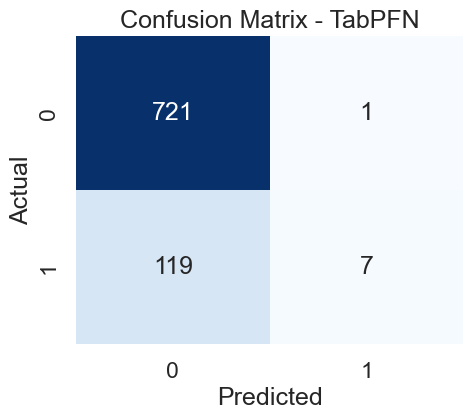

In [ ]:
from tabpfn import TabPFNClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Model ---
tabpfn = TabPFNClassifier(device="cpu", ignore_pretraining_limits=True)
tabpfn.fit(X_train, y_train)

# --- Predictions ---
y_pred_test_proba = tabpfn.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_test_proba >= 0.5).astype(int)

# --- Confusion Matrix ---
cm_test = confusion_matrix(y_test, y_pred_test)

TP = cm_test[1, 1]
FP = cm_test[0, 1]
TN = cm_test[0, 0]
FN = cm_test[1, 0]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# --- Plot ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - TabPFN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy for test set for TabICL = 0.8573113207547169

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       722
           1       1.00      0.04      0.08       126

    accuracy                           0.86       848
   macro avg       0.93      0.52      0.50       848
weighted avg       0.88      0.86      0.80       848



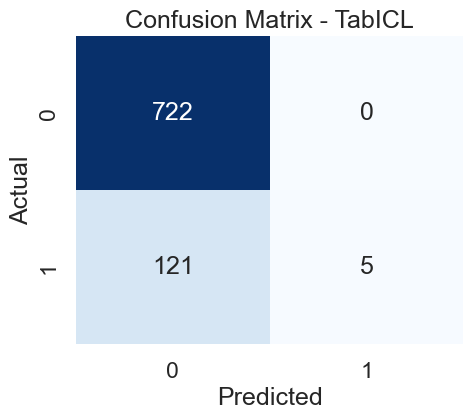

In [ ]:
from tabicl import TabICLClassifier

tabicl_model = TabICLClassifier()
tabicl_model.fit(X_train, y_train)

# --- Predictions ---
y_pred_test_proba = tabicl_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_test_proba >= 0.5).astype(int)

# --- Confusion Matrix ---
cm_test = confusion_matrix(y_test, y_pred_test)

TP = cm_test[1, 1]
FP = cm_test[0, 1]
TN = cm_test[0, 0]
FN = cm_test[1, 0]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# --- Plot ---
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - TabICL')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [263]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    balanced_accuracy_score
)

def print_metrics(name, y_true, y_pred, y_proba):
    print(f"{name} TEST Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"{name} TEST ROC-AUC: {roc_auc_score(y_true, y_proba):.3f}")
    print(f"{name} TEST PR-AUC: {average_precision_score(y_true, y_proba):.3f}")
    print(f"{name} TEST Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.3f}")


In [264]:
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= 0.5).astype(int)

print_metrics("XGBoost", y_test, y_test_pred, y_test_proba)


XGBoost TEST Accuracy: 0.860
XGBoost TEST ROC-AUC: 0.756
XGBoost TEST PR-AUC: 0.425
XGBoost TEST Balanced Accuracy: 0.528


In [ ]:
y_test_proba = tabpfn_model.predict_proba(X_test.values)[:, 1]
y_test_pred  = (y_test_proba >= 0.5).astype(int)

print_metrics("TabPFN", y_test, y_test_pred, y_test_proba)


TabPFN TEST Accuracy: 0.861
TabPFN TEST ROC-AUC: 0.729
TabPFN TEST PR-AUC: 0.382
TabPFN TEST Balanced Accuracy: 0.535


In [267]:
y_test_proba = tabicl_model.predict_proba(X_test.values)[:, 1]
y_test_pred  = (y_test_proba >= 0.5).astype(int)

print_metrics("TabICL", y_test, y_test_pred, y_test_proba)


c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but TabICLClassifier was fitted with feature names
  warnings.warn(
c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


TabICL TEST Accuracy: 0.857
TabICL TEST ROC-AUC: 0.702
TabICL TEST PR-AUC: 0.350
TabICL TEST Balanced Accuracy: 0.520


c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but TabICLClassifier was fitted with feature names
  warnings.warn(
c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


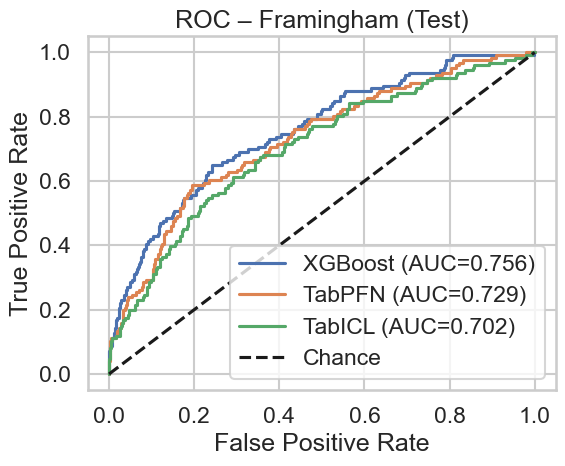

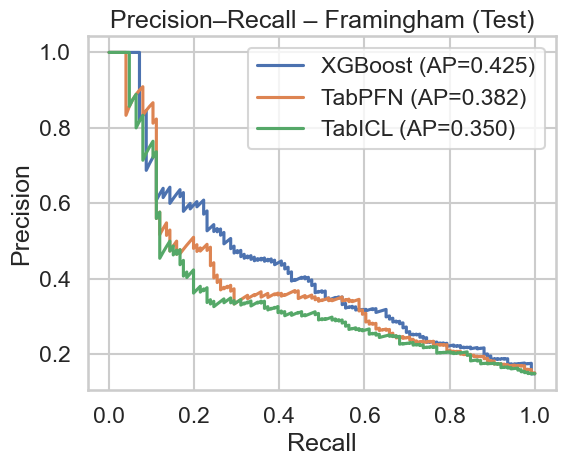

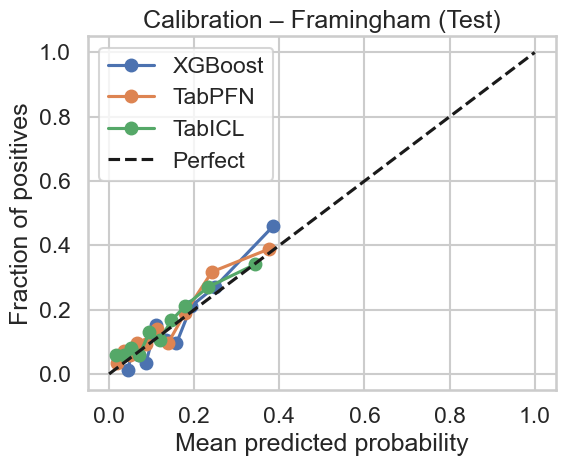

In [271]:

from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve


test_probas = {
    "XGBoost": xgb_model.predict_proba(X_test)[:, 1],
    "TabPFN": tabpfn_model.predict_proba(X_test.values)[:, 1],
    "TabICL": tabicl_model.predict_proba(X_test.values)[:, 1],
}

test_labels = y_test



def plot_roc(y_true, probas_dict, title):
    plt.figure(figsize=(6,5))
    for name, proba in probas_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1], [0,1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_pr(y_true, probas_dict, title):
    plt.figure(figsize=(6,5))
    for name, proba in probas_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, proba)
        ap = average_precision_score(y_true, proba)
        plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_calibration(y_true, probas_dict, title):
    plt.figure(figsize=(6,5))
    for name, proba in probas_dict.items():
        frac_pos, mean_pred = calibration_curve(
            y_true, proba, n_bins=10, strategy="quantile"
        )
        plt.plot(mean_pred, frac_pos, marker="o", label=name)
    plt.plot([0,1], [0,1], "k--", label="Perfect")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()



plot_roc(test_labels, test_probas, "ROC – Framingham (Test)")
plot_pr(test_labels, test_probas, "Precision–Recall – Framingham (Test)")
plot_calibration(test_labels, test_probas, "Calibration – Framingham (Test)")


 Foundation models outperformed classical gradient boosting on small, noisy clinical datasets (UCI Heart and Statlog) and in high-dimensional CAC prediction, but did not consistently surpass XGBoost on the larger, structured Framingham cohort.
 
These results indicate that foundation models offer the greatest benefit in low-sample or complex data regimes, while classical methods remain competitive in large, well-curated epidemiological datasets

####  Pima Indian Diabetes Dataset taken from https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

##### Number of Attributes: 8 plus class

For Each Attribute: (all numeric-valued) 
1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
Diabetes pedigree function
7. Age (years)

Class variable (0 or 1)
Missing Attribute Values: Yes
Class Distribution: (class value 1 is interpreted as "tested positive for
diabetes")

In [ ]:
data3 = pd.read_excel(r"C:\Users\lavan\Downloads\RA_NUIG\datasets\diabetes.xlsx", na_values=["", " ", "NA", "N/A"])
data3 = data3.replace(r"^\s*$", pd.NA, regex=True)

In [148]:
data3.shape
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [152]:
zero_as_missing = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI"
]
data3[zero_as_missing] = data3[zero_as_missing].replace(0, np.nan)


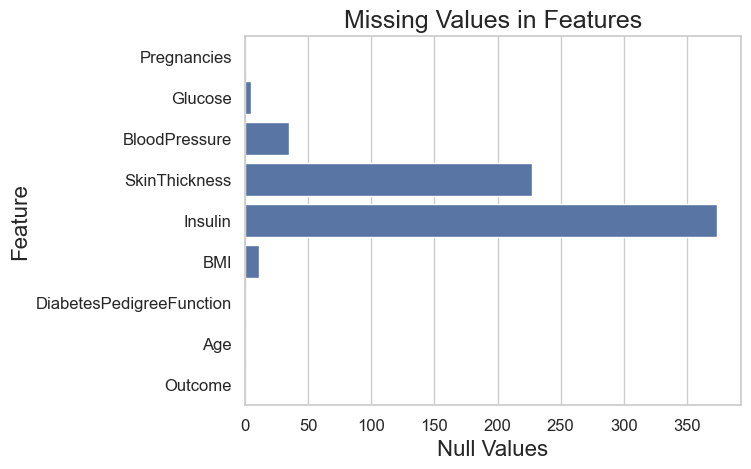

In [153]:
df_null = pd.DataFrame(data3.isnull().sum().reset_index())
df_null.columns = ['feature', 'null_values']
df_null

# Barchart for null values
sns.barplot(y=df_null['feature'], x=df_null['null_values'], orient='h')
plt.title('Missing Values in Features', fontsize=18)
plt.xlabel('Null Values', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


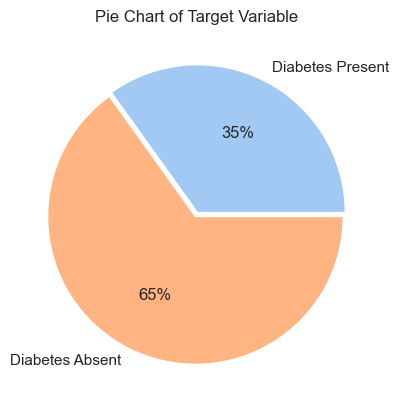

In [155]:
# Pie-chart of Target feature - diabetes

unique_values = data3['Outcome'].unique()
counts = data3['Outcome'].value_counts().sort_values()
percentages = counts / counts.sum() * 100
plt.pie(percentages, labels=[ 'Diabetes Present', 'Diabetes Absent'],
        colors= seaborn.color_palette('pastel'), explode=[0.02,0.01], autopct='%.0f%%')
plt.title('Pie Chart of Target Variable')
plt.show()

In [158]:
X_pima = data3.drop(columns=["Outcome"])
y_pima = data3["Outcome"].values


In [160]:
data3.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')